In [1]:
from vectorhash_imported import *
from vectorhash_convered import *
from nd_scaffold import GridScaffold
import math
from scipy.stats import norm


lambdas = [3,4,5]
shapes = [(i, i) for i in lambdas]
percent_nonzero_relu = 0.99
W_gh_var = 1
sparse_initialization = 0.6
T = 0.00005
W_hg_std = math.sqrt(W_gh_var)
W_hg_mean = -W_hg_std * norm.ppf(1 - percent_nonzero_relu) / math.sqrt(len(lambdas))
h_normal_mean = len(lambdas) * W_hg_mean
h_normal_std = math.sqrt(len(lambdas)) * W_hg_std
relu_theta = math.sqrt((1 - sparse_initialization) * len(lambdas)) * norm.ppf(
    1 - percent_nonzero_relu
)
num_imgs = 200

print(percent_nonzero_relu, W_hg_mean, W_hg_std, h_normal_mean, h_normal_std, relu_theta)

GS = GridScaffold(
    shapes=shapes,
    N_h=1200,
    input_size=784,
    h_normal_mean=h_normal_mean,
    h_normal_std=h_normal_std,
    device=None,
    sparse_matrix_initializer=SparseMatrixBySparsityInitializer(
        sparsity=sparse_initialization, device="cpu"
    ),
    relu_theta=relu_theta, ######
    from_checkpoint=False,
    T=T,
    continualupdate=False,
    ratshift=False,
    initialize_W_gh_with_zeroes=False,
    pseudo_inverse=False,
    batch_update=False,
    use_h_fix=False,
    learned_pseudo=False,
    epsilon=0.01,
    calculate_update_scaling_method="n_h",
    MagicMath=False,
    sanity_check=False,
    calculate_g_method="fast",
)

0.99 1.3431175713061931 1.0 4.02935271391858 1.7320508075688772 -2.548386414432711
module shapes:  [(3, 3), (4, 4), (5, 5)]
N_g     :  50
N_patts :  3600
N_h     :  1200


In [2]:
def prepare_data(
    dataset,
    num_imgs=5,
    preprocess_sensory=True,
    noise_level="medium",
    use_fix=False,
):
    import torch
    import random

    data = dataset.train_data.flatten(1)[:num_imgs].float().to("cpu")
    # data = random.sample(dataset.data.flatten(1).float().to("cpu"), num_imgs)
    if preprocess_sensory:
        # if use_fix:
        #     for i in range(len(data)):
        #         data[i] = (data[i] - data[i].mean()) / data[i].std()

        data = (data - data.mean(dim=0)) / (data.std(dim=0) + 1e-8)
    # noissing the data
    if noise_level == "none":
        return data, data
    elif noise_level == "low":
        random_noise = torch.zeros_like(data).uniform_(-1, 1)
    elif noise_level == "medium":
        random_noise = torch.zeros_like(data).uniform_(-1.25, 1.25)
    elif noise_level == "high":
        random_noise = torch.zeros_like(data).uniform_(-1.5, 1.5)
    noisy_data = data + random_noise

    return data, noisy_data

def prepare_data_random(noise_scale=0.1):
    data = torch.randn((num_imgs, 784))
    noise = noise_scale * torch.randn((num_imgs, 784))
    return data, data + noise

In [3]:
from vectorhash_functions import solve_mean, spacefillingcurve
import torchvision
from torchvision import transforms
import torch

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: x.flatten())]
)

dataset = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)

data, noisy_data = prepare_data(
    dataset,
    num_imgs=num_imgs,
    preprocess_sensory=True,
    noise_level="none",
    use_fix=True
)
# data, noisy_data = prepare_data_random(noise_scale=0) 


v = spacefillingcurve(shapes)

g_positions, g_positions2, g_points, g_points_2 = GS.learn_path(observations=data, velocities=v[: len(data)])
recalled_imgs = GS.recall(noisy_data)
similarity = torch.cosine_similarity(data, recalled_imgs, dim=1)
print(similarity.mean())



/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
200it [00:02, 96.97it/s] 


Unique Gs seen while learning: 200
Unique Hs seen while learning: 200
Unique Hs seen while recalling: 0
Unique Gs seen while recalling (right after learning): 0
Unique Gs seen while recalling (right after learning, after denoising): 0
Unique Gs seen while learning (after denoising): 200
Unique Hs seen while recalling: 200
Unique Gs seen while recalling (before denoising): 200
Unique Gs seen while recalling (after denoising): 139
Unique Hs seen while recalling (after denoising): 139
avg nonzero H: 1176.9599609375
avg nonzero H_denoised: 1179.8800048828125
tensor(0.4081)


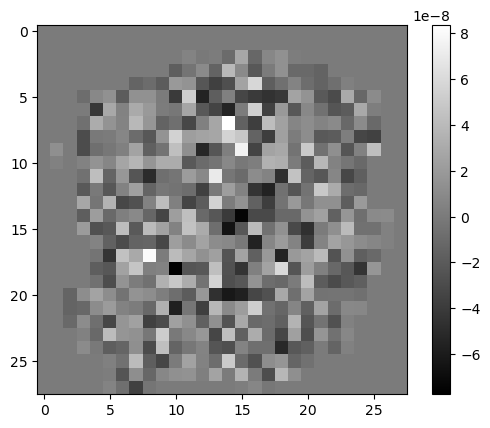

In [4]:
plt.imshow(data.mean(dim=0).reshape(28, 28), cmap="gray")
plt.colorbar()

In [5]:
from vectorhash_functions import *

mod_n_positions = []
mod_n_positions_2 = []
mod_n_states = []
mod_n_states_2 = []

# assume shapes are squares

for _ in lambdas:
    mod_n_positions.append(list())
    mod_n_positions_2.append(list())
    mod_n_states.append(list())
    mod_n_states_2.append(list())

for g in g_positions:
    pos = 0
    for i, l in enumerate(lambdas):
        mod_n = g[pos : pos + l**2]
        mod_n_positions[i].append(ConvertToXYNew(mod_n, (l, l)))
        pos += l**2

for g in g_positions2:
    pos = 0
    for i, l in enumerate(lambdas):
        mod_n = g[pos : pos + l**2]
        mod_n_positions_2[i].append(ConvertToXYNew(mod_n, (l, l)))
        pos += l**2

for g in g_points:
    pos = 0
    for i, l in enumerate(lambdas):
        mod_n = g[pos : pos + l**2]
        mod_n_states[i].append(ConvertToXYNew(mod_n, (l, l)))
        pos += l**2

for g in g_points_2:
    pos = 0
    for i, l in enumerate(lambdas):
        mod_n = g[pos : pos + l**2]
        mod_n_states_2[i].append(ConvertToXYNew(mod_n, (l, l)))
        pos += l**2

200
199
200
199


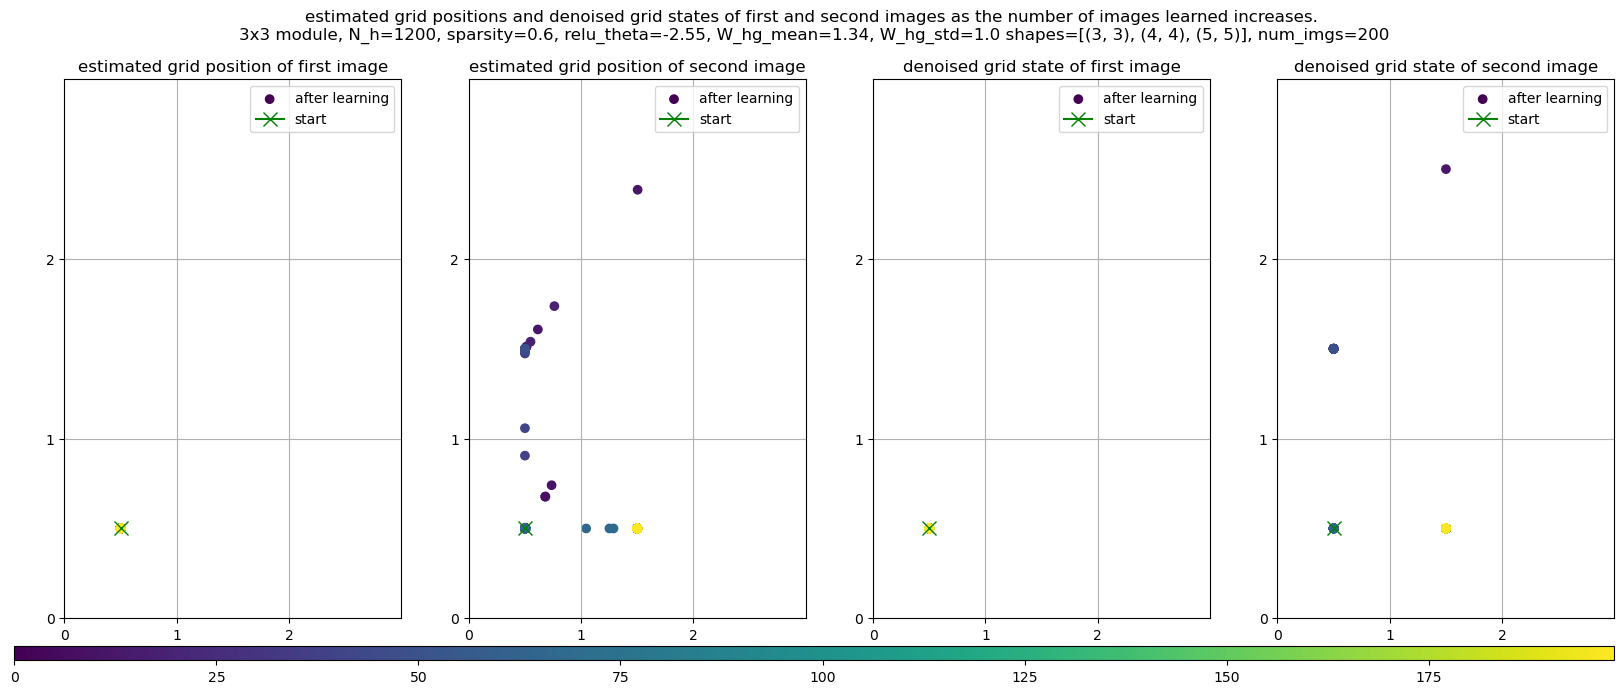

200
199
200
199


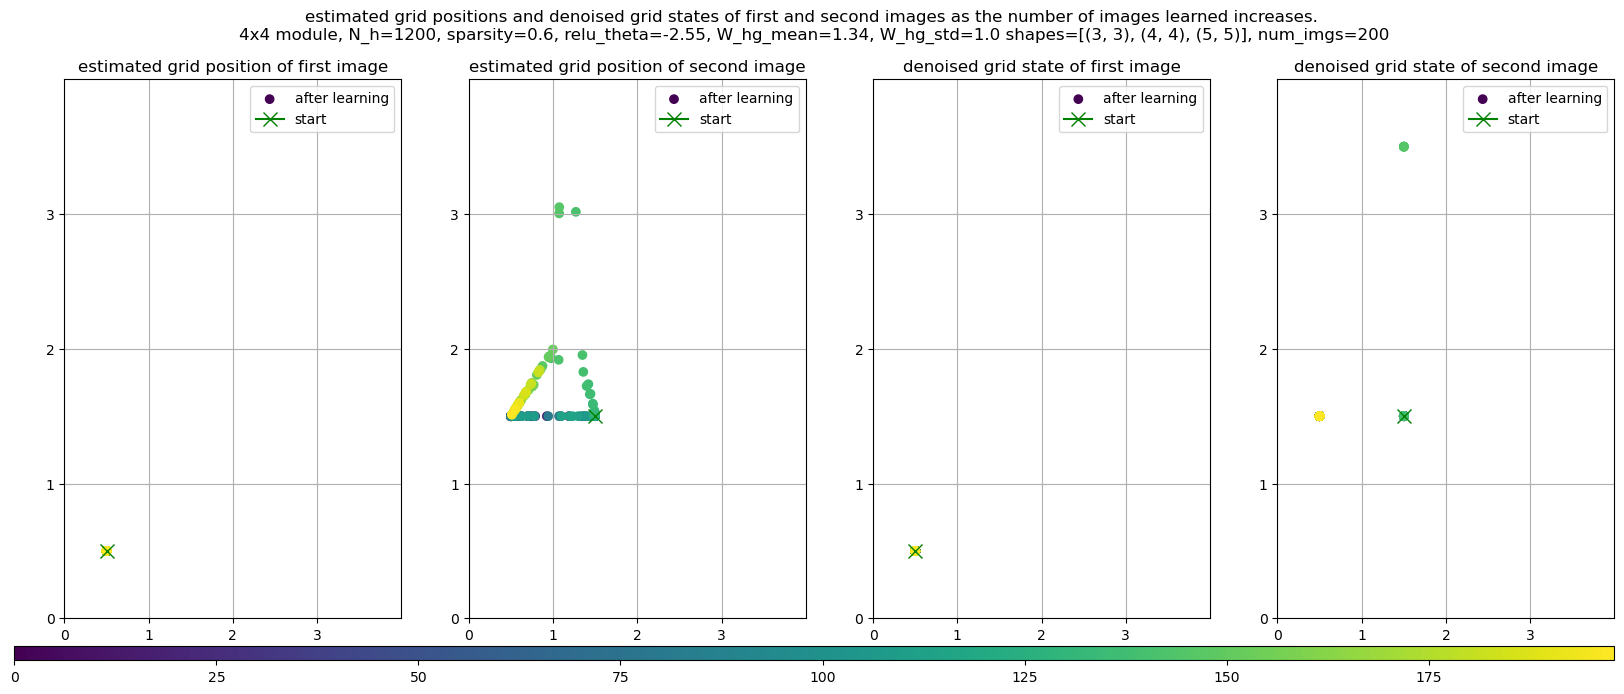

200
199
200
199


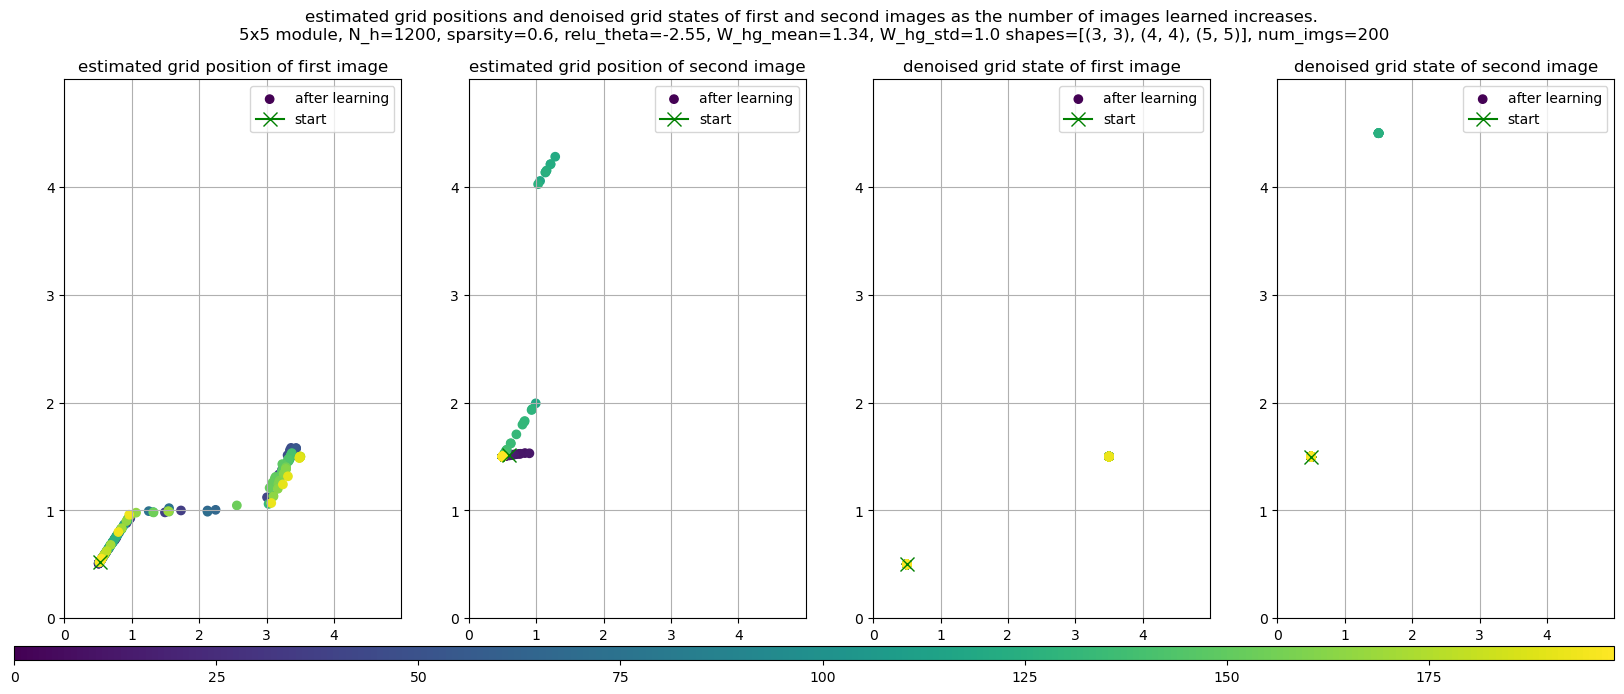

In [6]:
for i, l in enumerate(lambdas):
    GraphGrids(
        shapes_lists=[(l, l), (l, l), (l, l), (l, l)],
        points_lists=[
            mod_n_positions[i],
            mod_n_positions_2[i],
            mod_n_states[i],
            mod_n_states_2[i],
        ],
        first_points=[
            mod_n_positions[i][0],
            mod_n_positions_2[i][0],
            mod_n_states[i][0],
            mod_n_states_2[i][0],
        ],
        titles=[
            f"estimated grid position of first image",
            f"estimated grid position of second image",
            f"denoised grid state of first image",
            f"denoised grid state of second image",
        ],
        main_title=f"estimated grid positions and denoised grid states of first and second images as the number of images learned increases. \n{l}x{l} module, N_h={GS.N_h}, sparsity={round(sparse_initialization, 2)}, relu_theta={round(relu_theta, 2)}, W_hg_mean={round(W_hg_mean, 2)}, W_hg_std={W_hg_std} shapes={shapes}, num_imgs={num_imgs}",
    )

In [7]:
# graph estimated position of each image

In [8]:
print(data.shape)

torch.Size([200, 784])


200
200


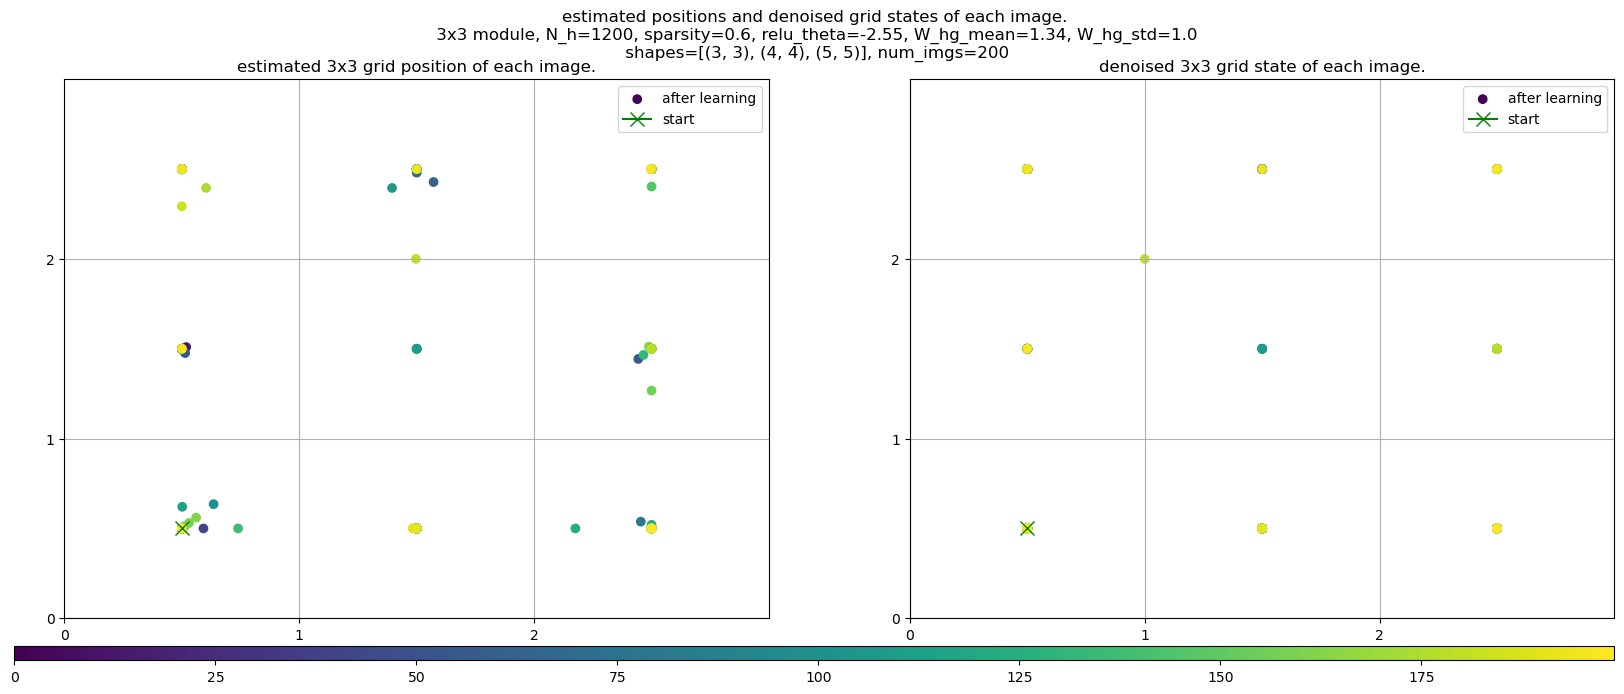

200
200


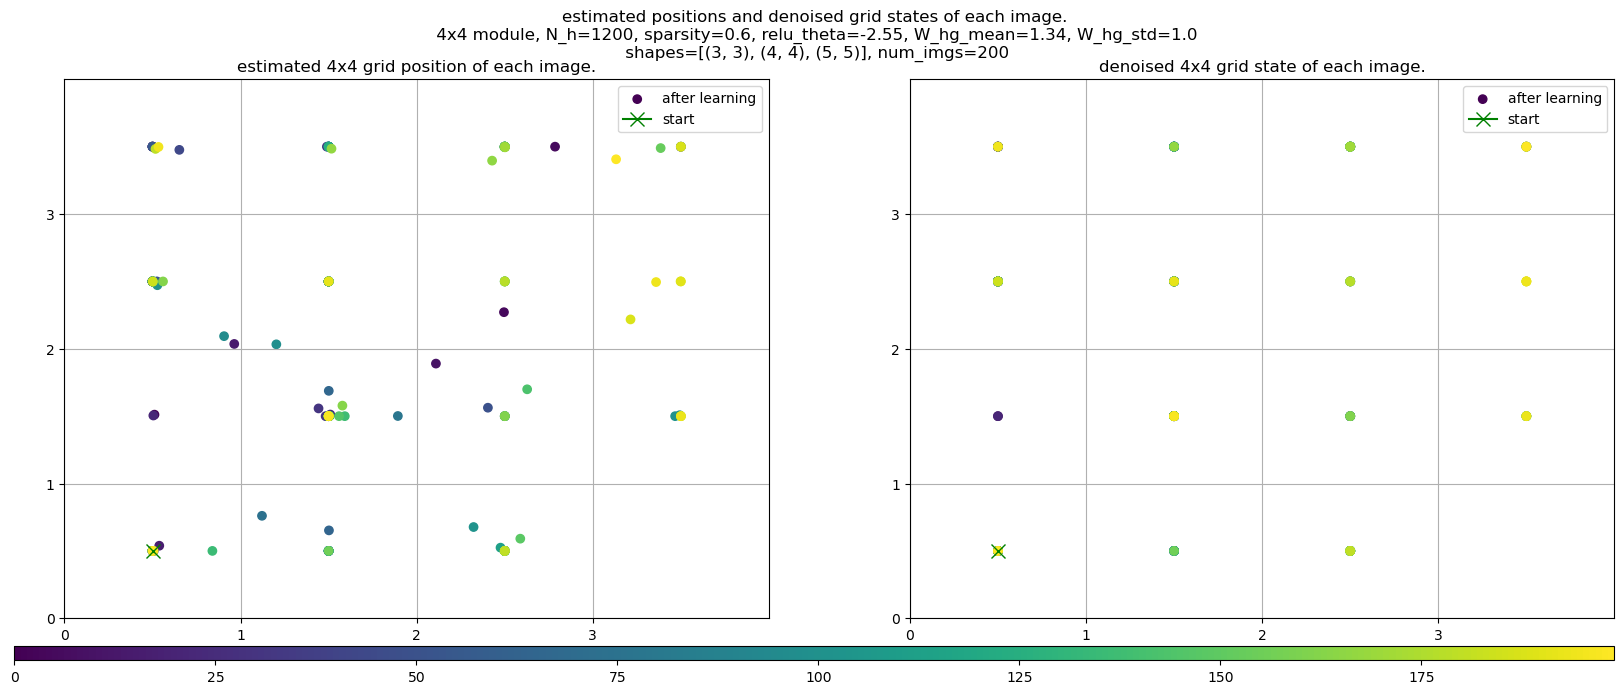

200
200


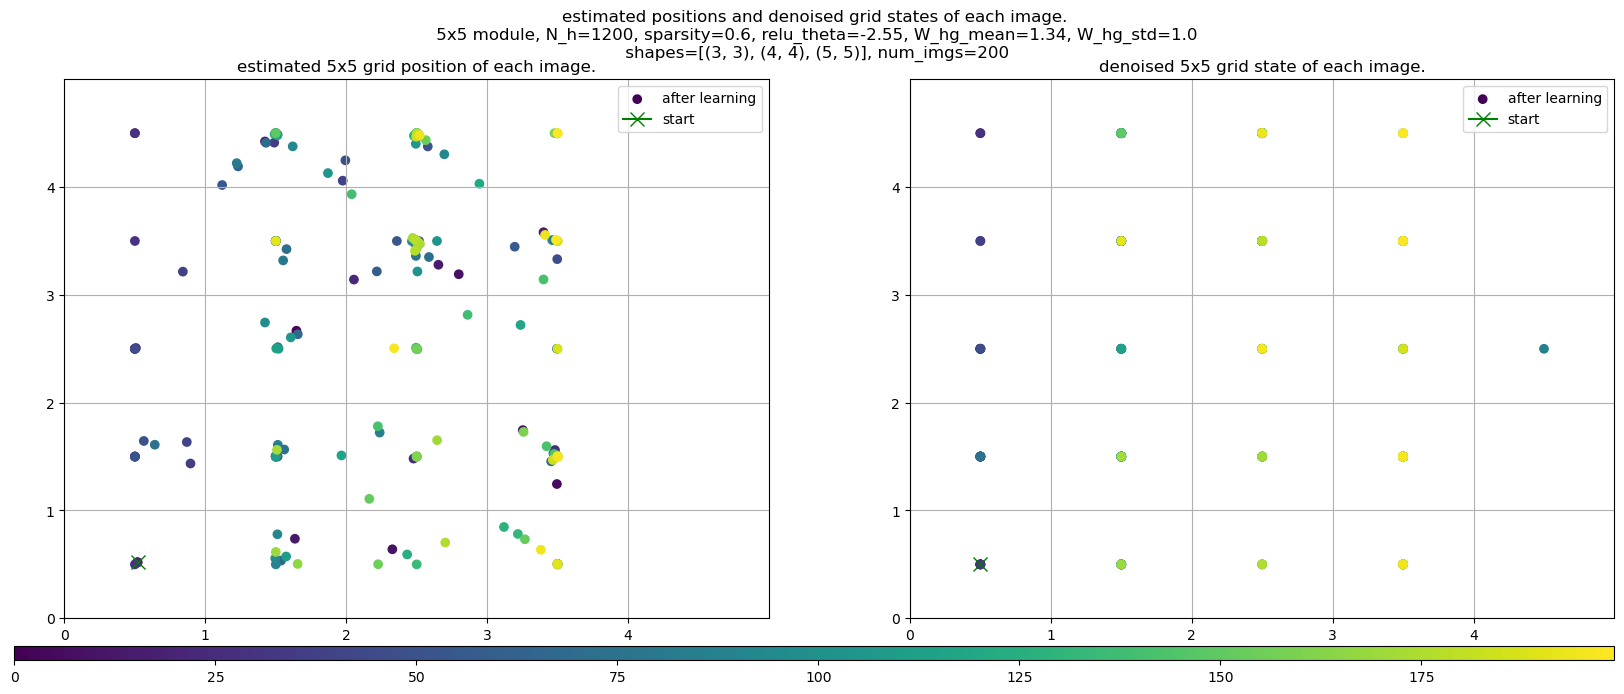

In [9]:
point_positions_n = []
point_states_n = []
for l in lambdas:
    point_positions_n.append([])
    point_states_n.append([])

for img in data:
    pos = GS.estimate_position(img)
    state = GS.denoise(
        GS.grid_from_hippocampal(GS.hippocampal_from_sensory(img))
    ).flatten()

    p = 0
    for i, l in enumerate(lambdas):
        point_positions_n[i].append(ConvertToXYNew(pos[p : p + l**2], (l, l)))
        point_states_n[i].append(ConvertToXYNew(state[p : p + l**2], (l, l)))
        p += l**2

for i, l in enumerate(lambdas):
    GraphGrids(
        shapes_lists=[(l, l), (l, l)],
        points_lists=[point_positions_n[i], point_states_n[i]],
        first_points=[point_positions_n[i][0], point_states_n[i][0]],
        titles=[
            f"estimated {l}x{l} grid position of each image.",
            f"denoised {l}x{l} grid state of each image.",
        ],
        main_title=f"estimated positions and denoised grid states of each image.\n {l}x{l} module, N_h={GS.N_h}, sparsity={round(sparse_initialization, 2)}, relu_theta={round(relu_theta,2 )}, W_hg_mean={round(W_hg_mean, 2)}, W_hg_std={W_hg_std}\n shapes={shapes}, num_imgs={num_imgs}",
    )

Unique Hs seen while recalling: 1
Unique Gs seen while recalling (before denoising): 1
Unique Gs seen while recalling (after denoising): 1
Unique Hs seen while recalling (after denoising): 1
avg nonzero H: 1195.0
avg nonzero H_denoised: 1188.0
tensor(0.1735)


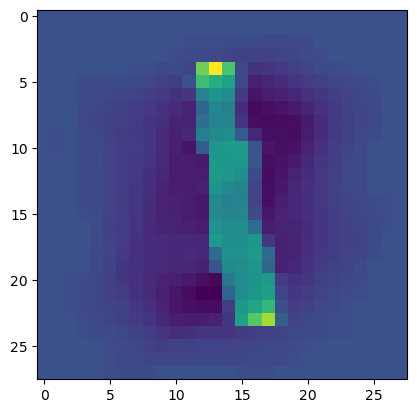

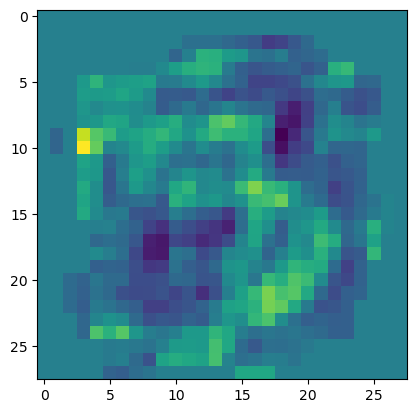

In [10]:
img = data[6]
recalled = GS.recall(img)
print(torch.cosine_similarity(img, recalled, dim=0).mean())

plt.imshow(img.reshape(28,28))
plt.show()
plt.imshow(recalled.reshape(28,28))
plt.show()



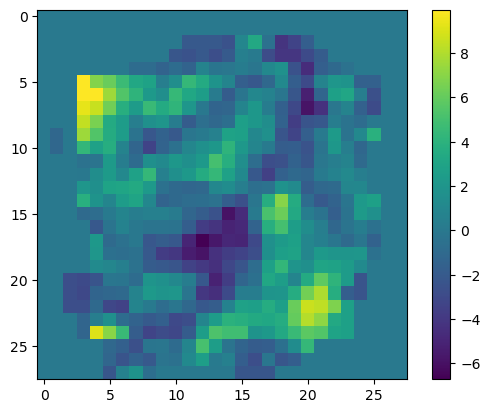

In [11]:
plt.imshow(GS.sensory_from_hippocampal(GS.hippocampal_from_grid(GS.G[3200])).reshape(28,28))
plt.colorbar()
plt.show()

/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/tmp/ipykernel_7635/154270520.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_by_class = torch.tensor(data).float().to("cpu")


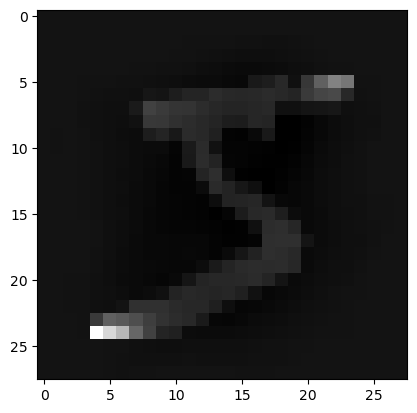

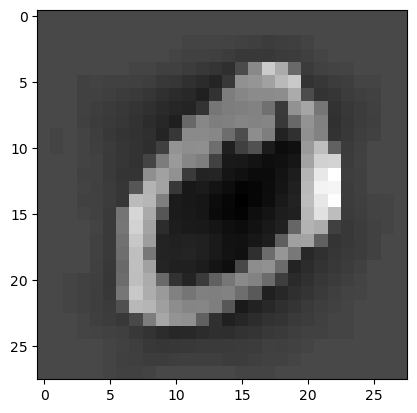

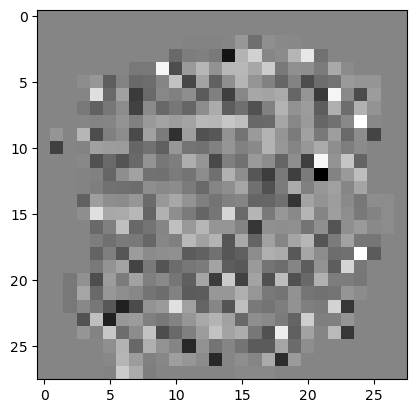

200
200


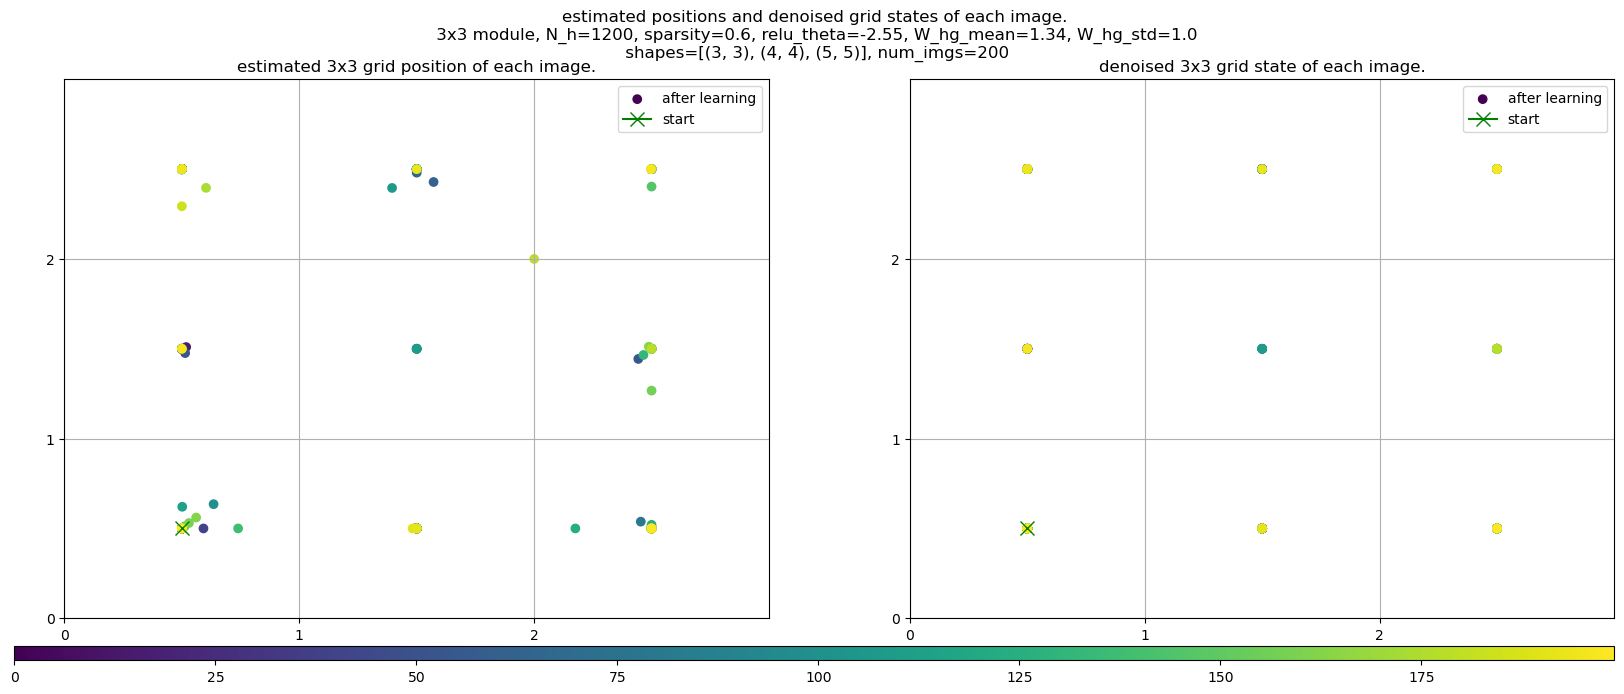

200
200


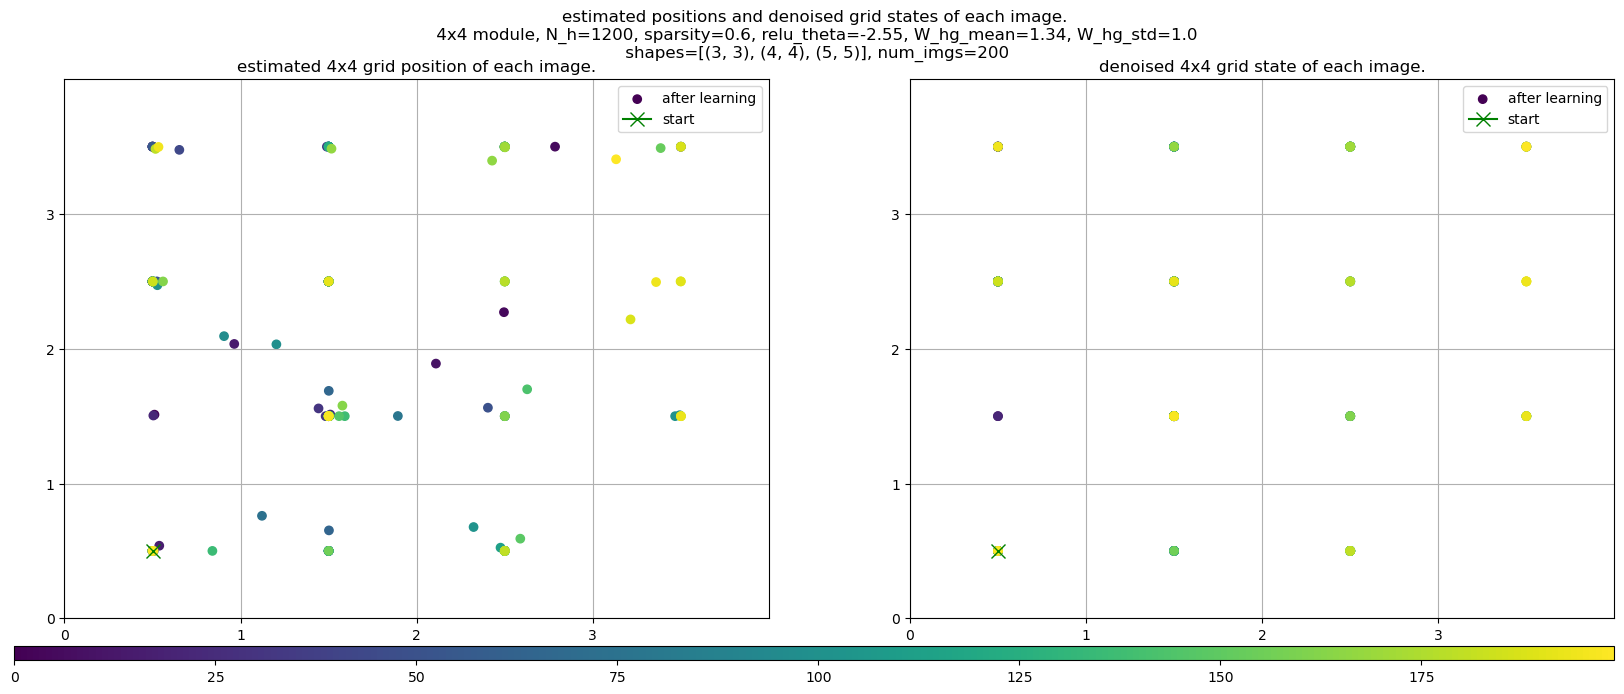

200
200


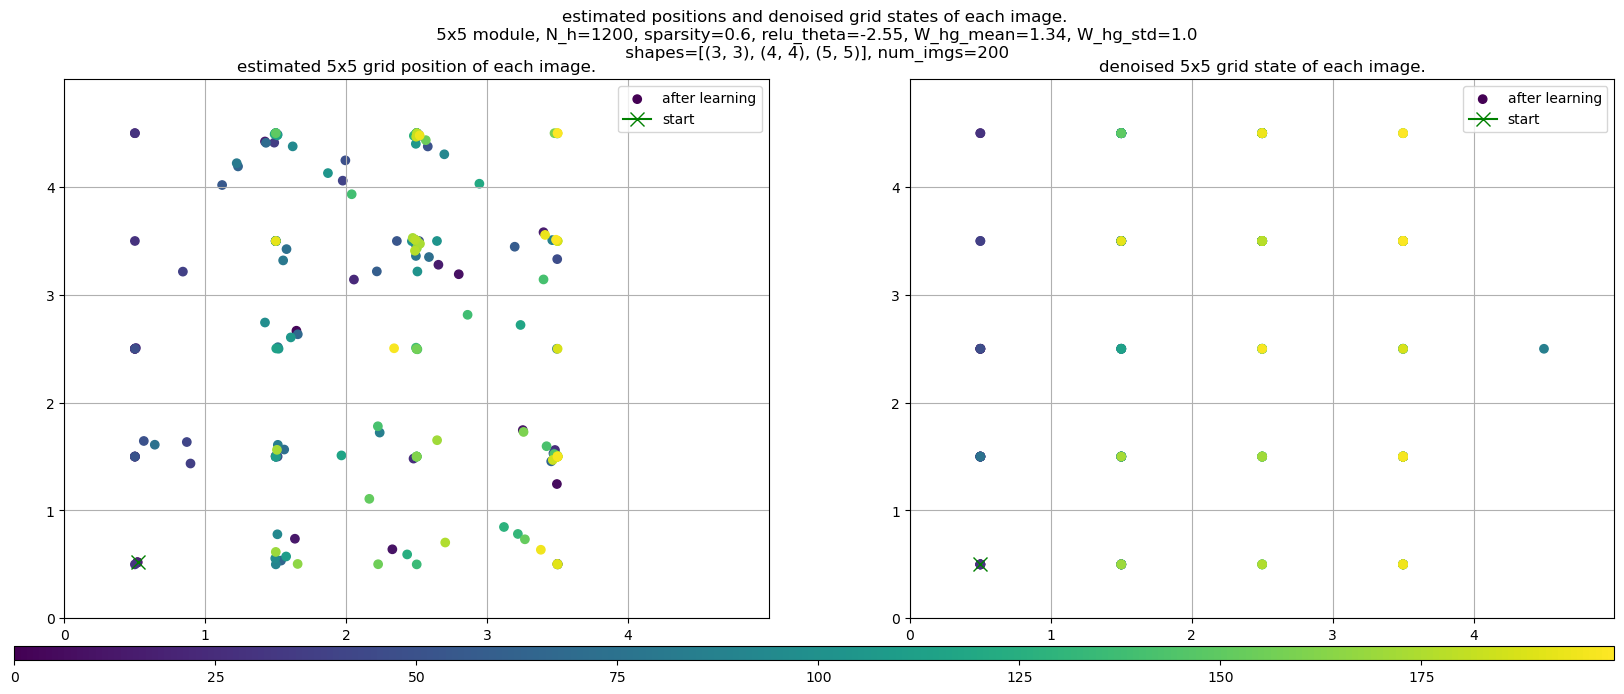

In [12]:
zero_indices = (dataset.train_labels == 0).nonzero().flatten()

data_by_class = dataset.data[zero_indices][:200].reshape(200, 784) 
data_by_class = torch.tensor(data).float().to("cpu")
data_by_class = (data - data.mean(dim=0)) / (data.std(dim=0)+1e-8)

plt.imshow(data_by_class[0].reshape(28, 28), cmap="gray")
plt.show()
plt.imshow(data_by_class[1].reshape(28, 28), cmap="gray")
plt.show()
plt.imshow(data_by_class.mean(dim=0).reshape(28, 28), cmap="gray")
plt.show()

point_positions_n = []
point_states_n = []
for l in lambdas:
    point_positions_n.append([])
    point_states_n.append([])

for img in data_by_class:
    pos = GS.estimate_position(img)
    state = GS.denoise(
        GS.grid_from_hippocampal(GS.hippocampal_from_sensory(img))
    ).flatten()

    p = 0
    for i, l in enumerate(lambdas):
        point_positions_n[i].append(ConvertToXYNew(pos[p : p + l**2], (l, l)))
        point_states_n[i].append(ConvertToXYNew(state[p : p + l**2], (l, l)))
        p += l**2

for i, l in enumerate(lambdas):
    GraphGrids(
        shapes_lists=[(l, l), (l, l)],
        points_lists=[point_positions_n[i], point_states_n[i]],
        first_points=[point_positions_n[i][0], point_states_n[i][0]],
        titles=[
            f"estimated {l}x{l} grid position of each image.",
            f"denoised {l}x{l} grid state of each image.",
        ],
        main_title=f"estimated positions and denoised grid states of each image.\n {l}x{l} module, N_h={GS.N_h}, sparsity={round(sparse_initialization, 2)}, relu_theta={round(relu_theta,2 )}, W_hg_mean={round(W_hg_mean, 2)}, W_hg_std={W_hg_std}\n shapes={shapes}, num_imgs={num_imgs}",
    )